In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv(r'/workspaces/MachineLearning/healthcare-dataset-stroke-data.csv')

print(df.head())
print(df.isnull().sum())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
id                     0
gender                 0
age   

In [51]:
from sklearn.utils import shuffle

majority_class = df[df['stroke'] == 0]  # Assuming class 0 is the majority class
minority_class = df[df['stroke'] == 1]  # Assuming class 1 is the minority class

#Randomly sample the majority class to match the minority class size
majority_class_undersampled = majority_class.sample(len(minority_class), random_state=42)

#Combine the undersampled majority class with the minority class
balanced_data = pd.concat([majority_class_undersampled, minority_class])

#Shuffle the datbase
balanced_data = shuffle(balanced_data, random_state=42)

#Split features and target
X = balanced_data.drop(columns=['stroke', 'id', 'ever_married', 'work_type', 'Residence_type', 'gender'])
Y = balanced_data['stroke']

print(X.describe())

              age  hypertension  heart_disease  avg_glucose_level         bmi
count  498.000000    498.000000     498.000000         498.000000  448.000000
mean    55.544498      0.180723       0.120482         119.334418   29.499107
std     21.342856      0.385175       0.325852          55.730541    7.445035
min      0.240000      0.000000       0.000000          55.930000   14.300000
25%     43.000000      0.000000       0.000000          77.122500   24.400000
50%     59.000000      0.000000       0.000000          97.955000   28.500000
75%     74.000000      0.000000       0.000000         152.442500   33.200000
max     82.000000      1.000000       1.000000         271.740000   92.000000


In [52]:
from sklearn.impute import KNNImputer, SimpleImputer

#Handle Different Variable Types
categorical = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical = X.select_dtypes(include=["number"]).columns.tolist()

#Potential way to incorporate bmi
X['bmi_missing'] = X['bmi'].isnull().astype(int)  # Add missing indicator column
X['bmi'] = X['bmi'].fillna(-1)                    # Impute with neutral value
numerical.append('bmi_missing')                   # Add to numerical list

#Handle non-numerical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat_encoded = encoder.fit_transform(X[categorical])
cat_col_names = encoder.get_feature_names_out(categorical)
X_cat_df = pd.DataFrame(X_cat_encoded, columns=cat_col_names, index=X.index)

#Reincorporate both variable types
X_final = pd.concat([X[numerical], X_cat_df], axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_final, Y, test_size=0.2, random_state=42)

#Test Prints
print(X_train.shape)
print(y_train.shape)

print(X_train.isnull().sum().sum())  # Should be 0
print(y_train.isnull().sum())        # Should be 0
print(X_test.isnull().sum().sum())  # Should be 0
print(y_test.isnull().sum())        # Should be 0

print(X_train.dtypes)
print(pd.Series(y_train).value_counts())
print(y_train)

(398, 10)
(398,)
0
0
0
0
age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
bmi_missing                         int64
smoking_status_Unknown            float64
smoking_status_formerly smoked    float64
smoking_status_never smoked       float64
smoking_status_smokes             float64
dtype: object
stroke
1    206
0    192
Name: count, dtype: int64
158     1
2052    0
3238    0
81      1
406     0
       ..
172     1
4073    0
5       1
3999    0
31      1
Name: stroke, Length: 398, dtype: int64


age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
bmi_missing                       0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


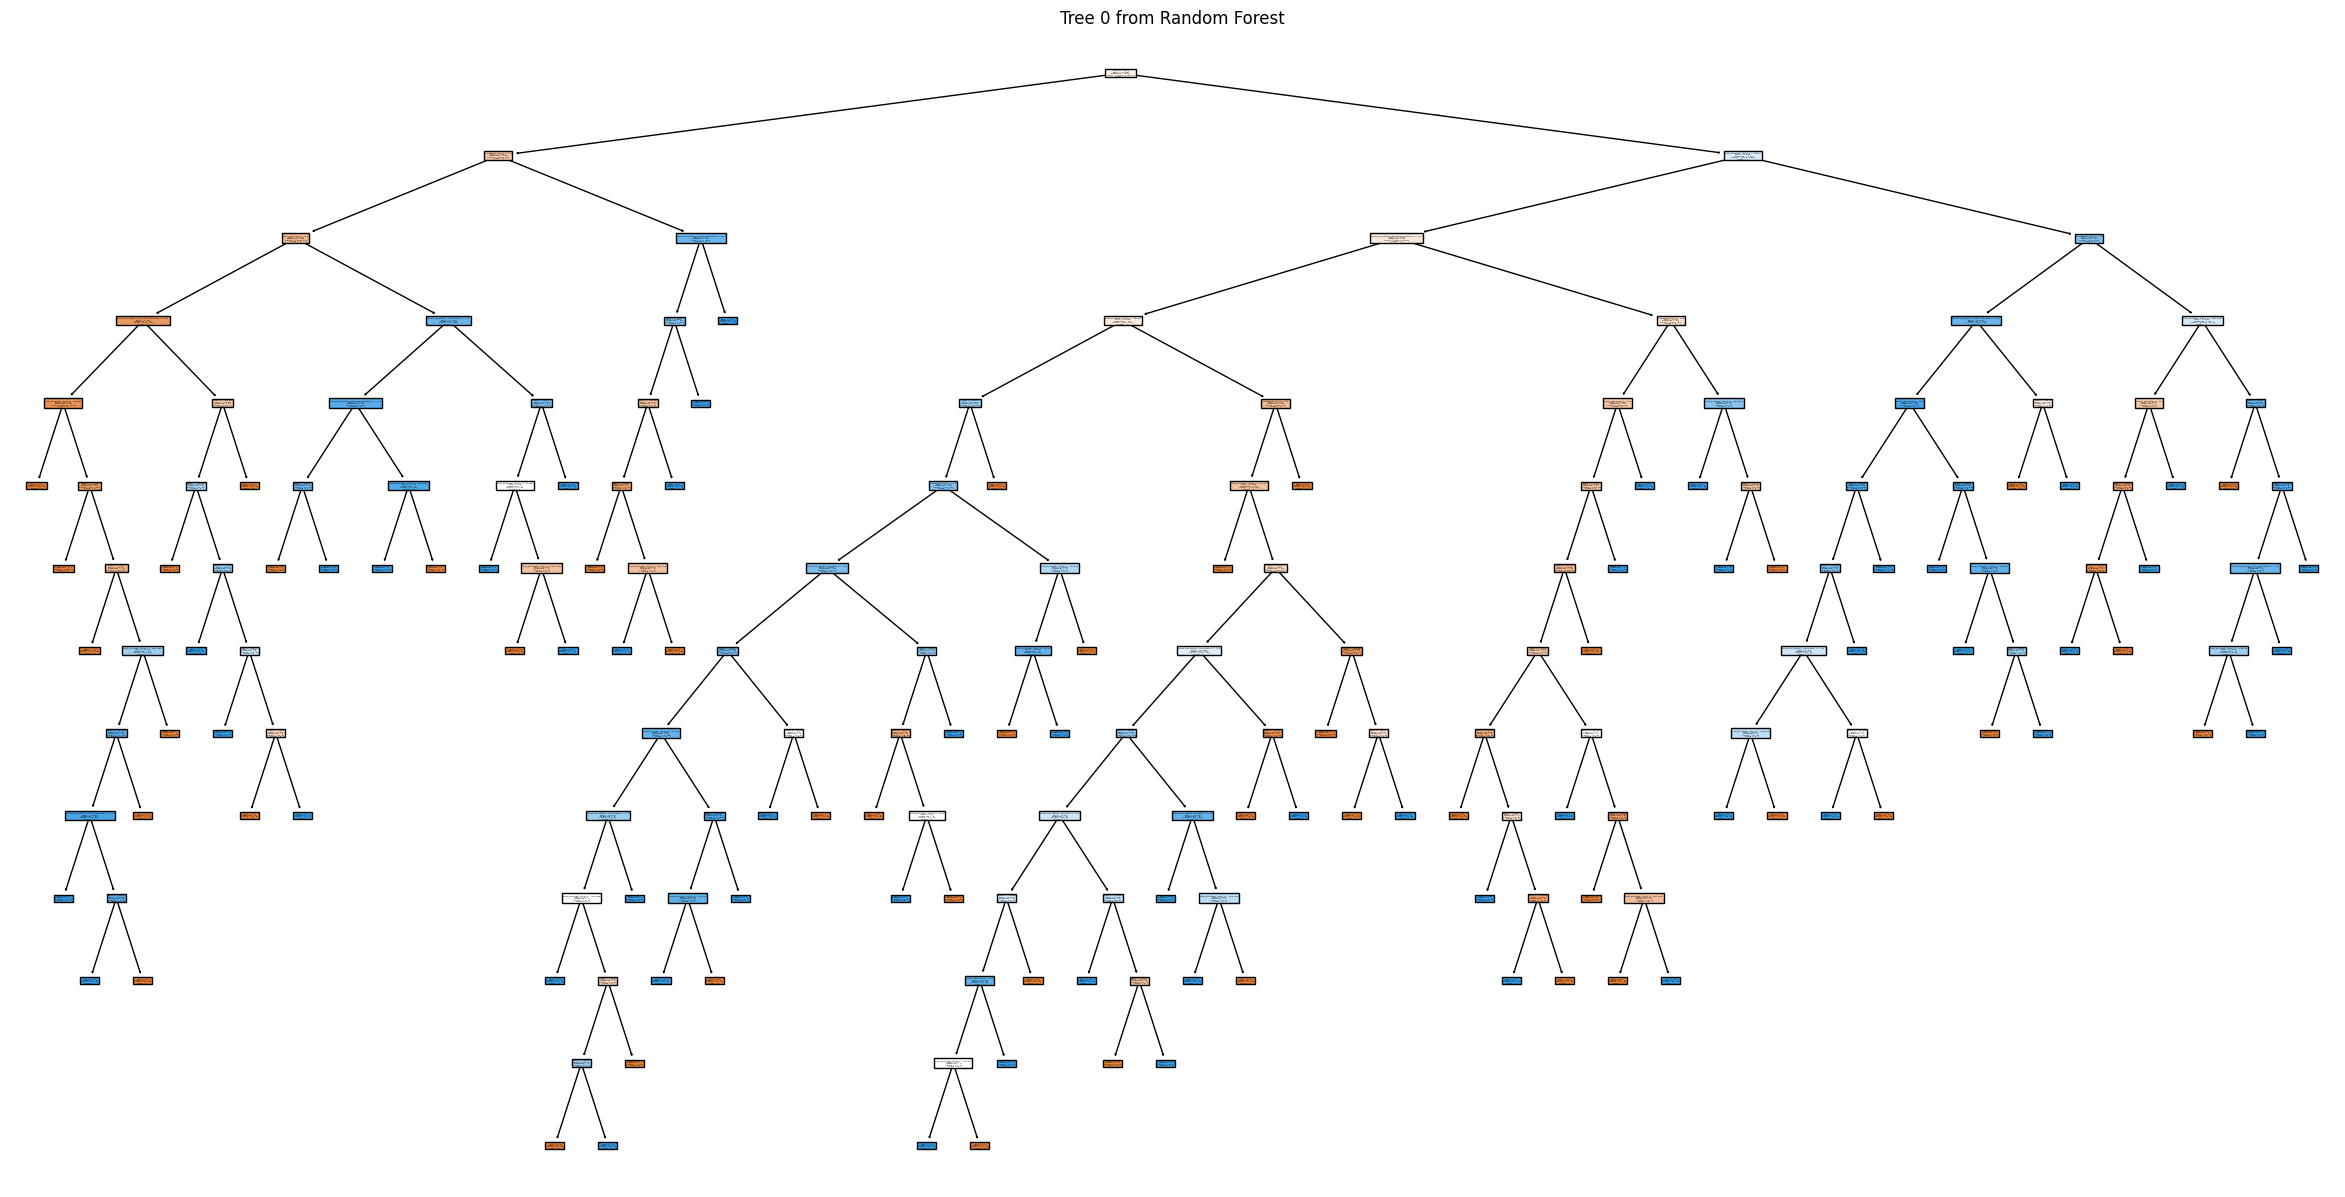

In [53]:
#Train the Decision Tree and Visualize
from sklearn.tree import plot_tree

#Initialize Random Forest Algorithm
Tree = RandomForestClassifier(random_state=42, n_estimators=100, max_depth= 20) #Could tinker here to refine where the trees stop
print(X_train.isnull().sum())
Tree.fit(X_train, y_train)

estimator = Tree.estimators_[0]  # Tree is your RandomForestClassifier

plt.figure(figsize=(30, 15))
plot_tree(estimator,
          filled=True,
          feature_names=X_train.columns,  # Make sure this matches the training data
          class_names=[str(cls) for cls in Tree.classes_])
plt.title("Tree 0 from Random Forest")
plt.show()

🔹 Classification Accuracy: 0.7700

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79        57
           1       0.71      0.79      0.75        43

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100

Precision: 0.708
Recall:    0.791
F1 Score:  0.747
AUC ROC Score: 0.773


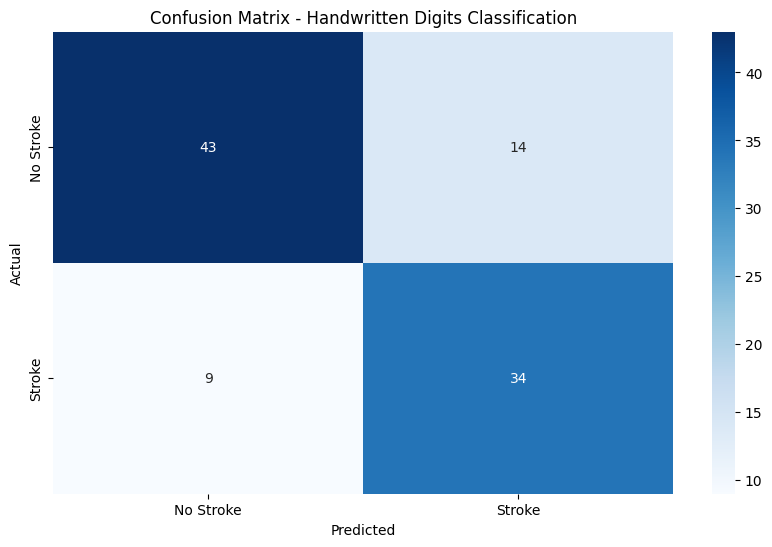

In [54]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

y_pred = Tree.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
print(f"🔹 Classification Accuracy: {accuracy:.4f}\n")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC ROC Score: {roc:.3f}")

# Confusion Matrix
plt.figure(figsize=(10, 6))
labels = ["No Stroke", "Stroke"]  # or just ["0", "1"] if you prefer

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            cmap="Blues", 
            fmt="d", 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Handwritten Digits Classification")
plt.show()

